In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [2]:
# Cell 2
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret,  corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
  
       
        #cv2.imshow('img',img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
np.savez("./calibration.npz",mtx=mtx, dist=dist)

try:
    calibration_param = np.load('./calibration.npz')
except IOError as e:
    print("There is no file like path")
else:
    dist = calibration_param['dist']   
    mtx = calibration_param['mtx']
       

In [3]:
# Cell 3
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist


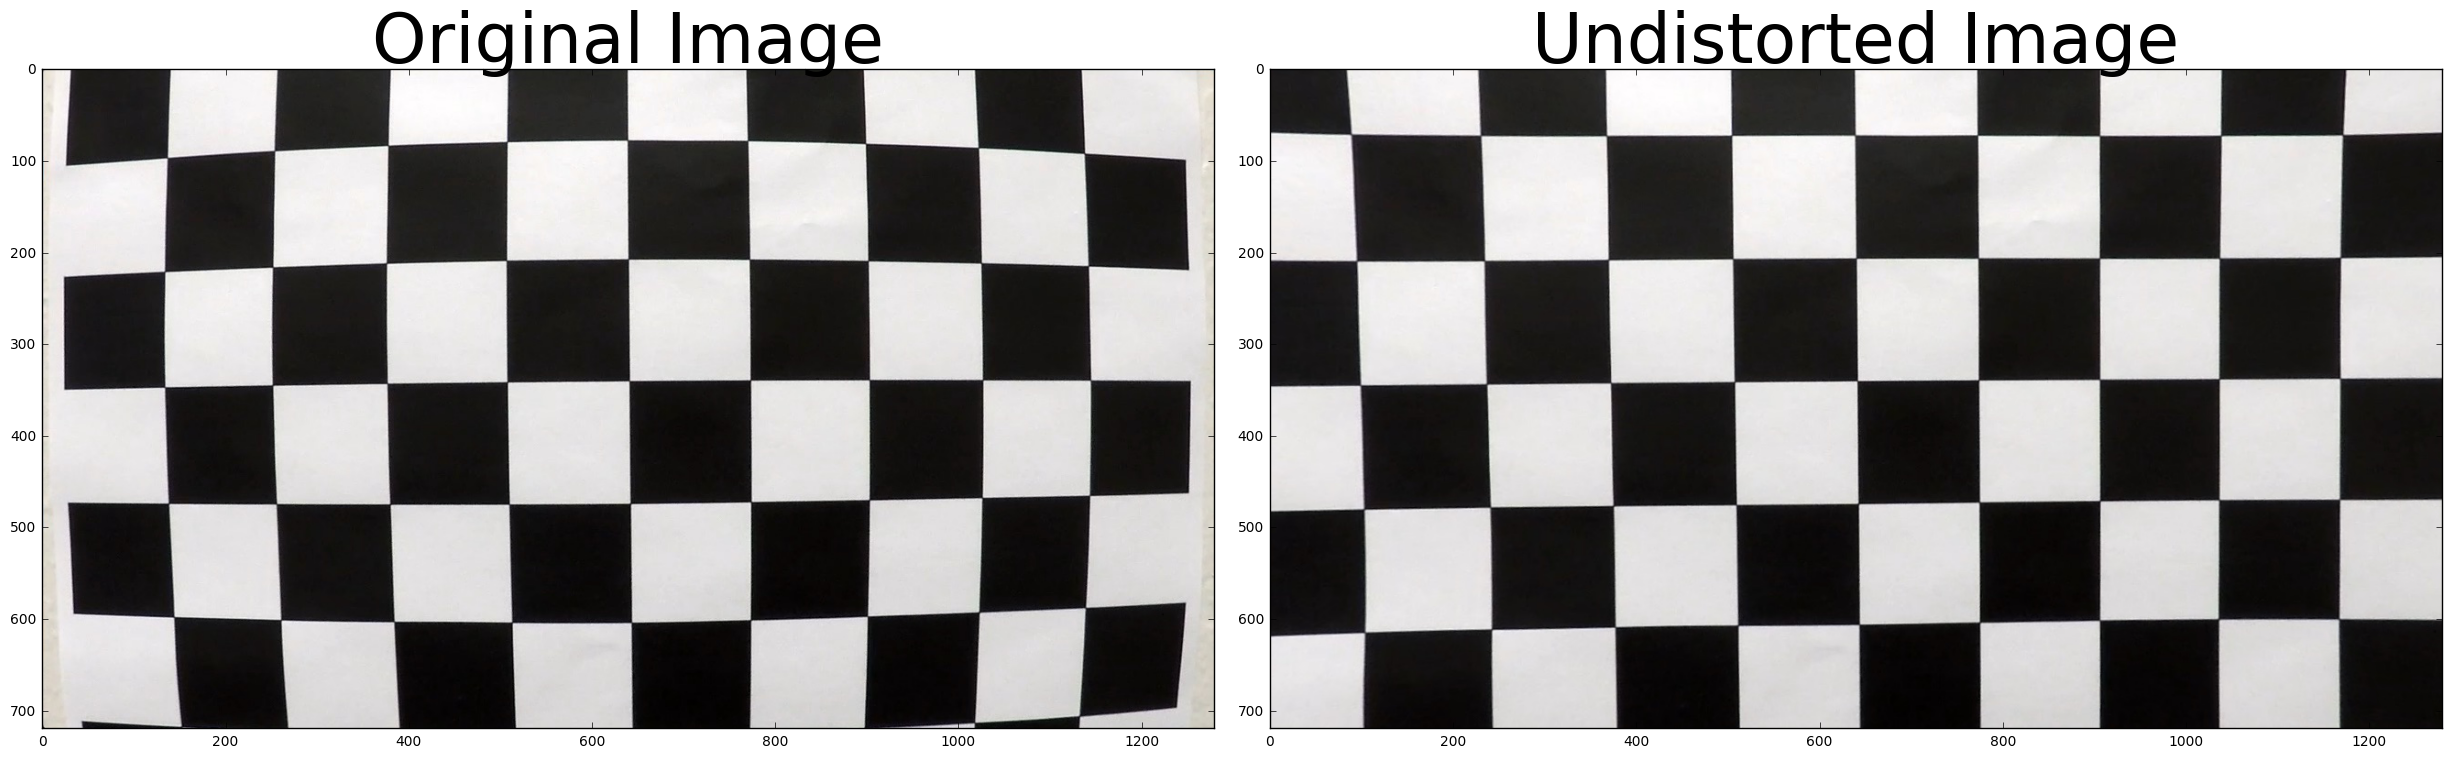

In [4]:
# Cell 4
image            =  mpimg.imread('./camera_cal/calibration1.jpg')
calibrated_image = cal_undistort(image,objpoints,imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(calibrated_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

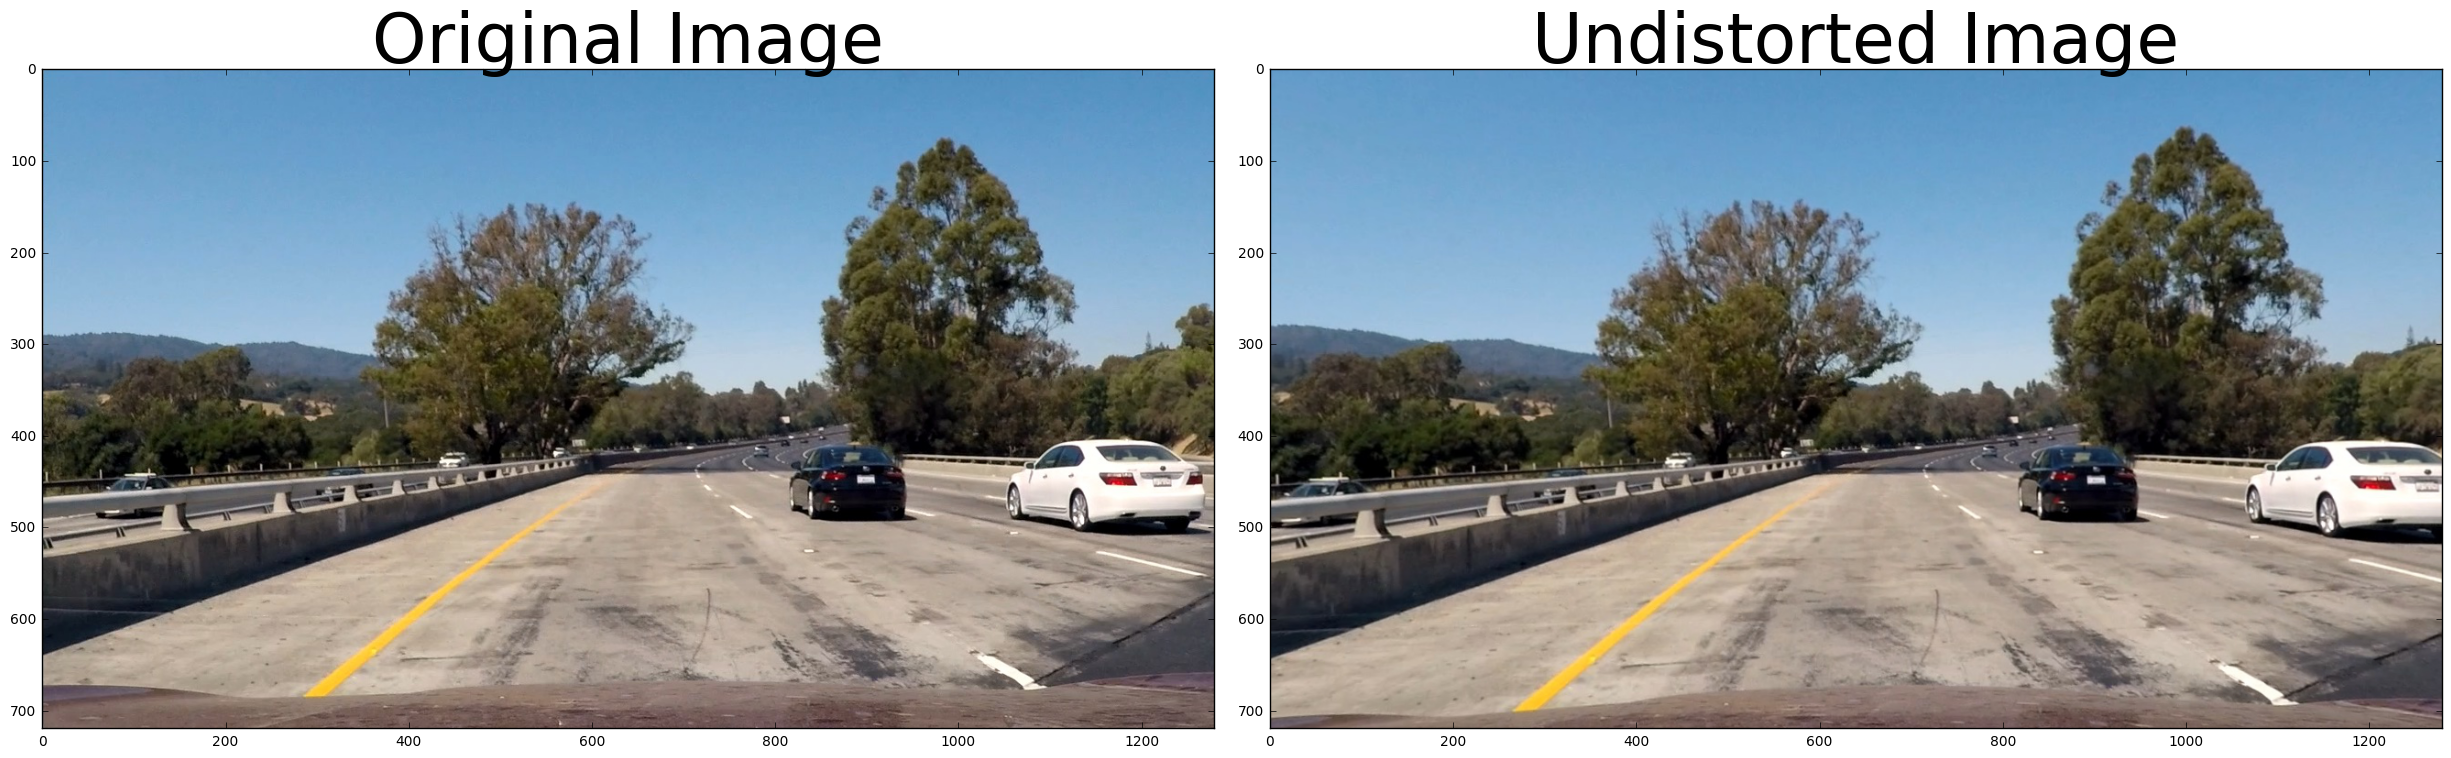

In [5]:
# Cell 5
image            =  mpimg.imread('./test_images/test1.jpg')
undistorted_image = cal_undistort(image,objpoints,imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [6]:
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3,thresh_min=0, thresh_max=255):
   
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    if orient == 'x':
       sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize= sobel_kernel)
       abs_sobelx = np.absolute(sobelx)
       scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
   
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary


In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    #absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dirx = np.arctan2(abs_sobely, abs_sobelx)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    binary = np.zeros_like(dirx)
    binary[(dirx >= thresh_min) & (dirx <= thresh_max)] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary


In [8]:
# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray  = np.copy(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    #scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    binary = np.zeros_like(gradmag)
    binary[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary


In [9]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [10]:
# Cell 10
def combined_thresh(img):
    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_select(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1) | ((mag_bin == 1) & (dir_bin == 1)) | (hls_bin ==1)] = 1

    return combined


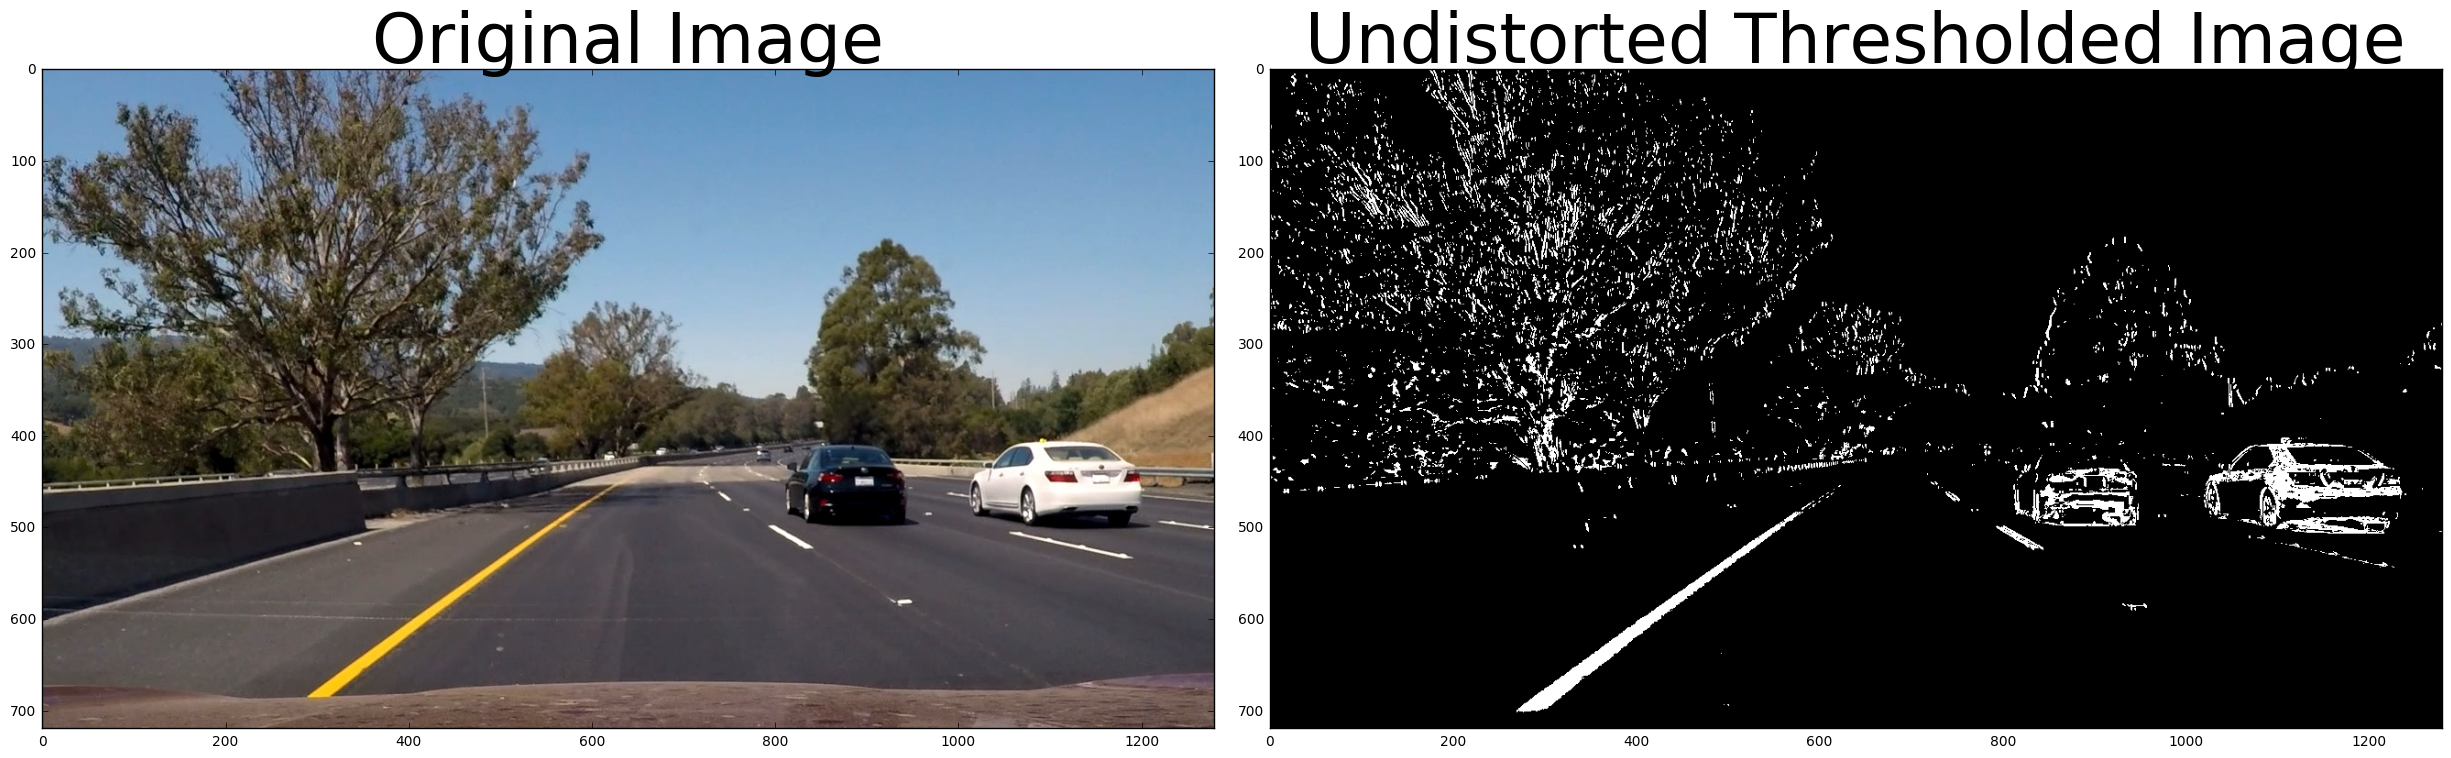

In [11]:
#Cell 11
image            =  mpimg.imread('./test_images/test6.jpg')
undistorted_image = cal_undistort(image,objpoints,imgpoints)
thresholded_image = combined_thresh(undistorted_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded_image,cmap='gray')
ax2.set_title('Undistorted Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
# Cell 12
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    #undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    #print (undistorted.shape)
    #gray = cv2.cvtColor(undistorted,cv2.COLOR_BGR2GRAY)
    #ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)
    
    #cv2.drawChessboardCorners(undistorted, (nx, ny), corners, ret)
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1],img.shape[0])
 
    #print (corners[0],corners[nx -1],corners[-1],corners[-nx])

        # For source points I'm grabbing the outer four detected corners
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
    #                                 [img_size[0]-offset, img_size[1]-offset], 
    #                                [offset, img_size[1]-offset]])
   
    src = np.float32([[1270, 710],
                      [0,    710],
                      [546, 460],
                      [732, 460]])
    dst = np.float32([[1280, 720],
                      [0, 720],
                      [0, 0],
                      [1280, 0]])




    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst,src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size,flags=cv2.INTER_LINEAR)
    return warped, M, Minv


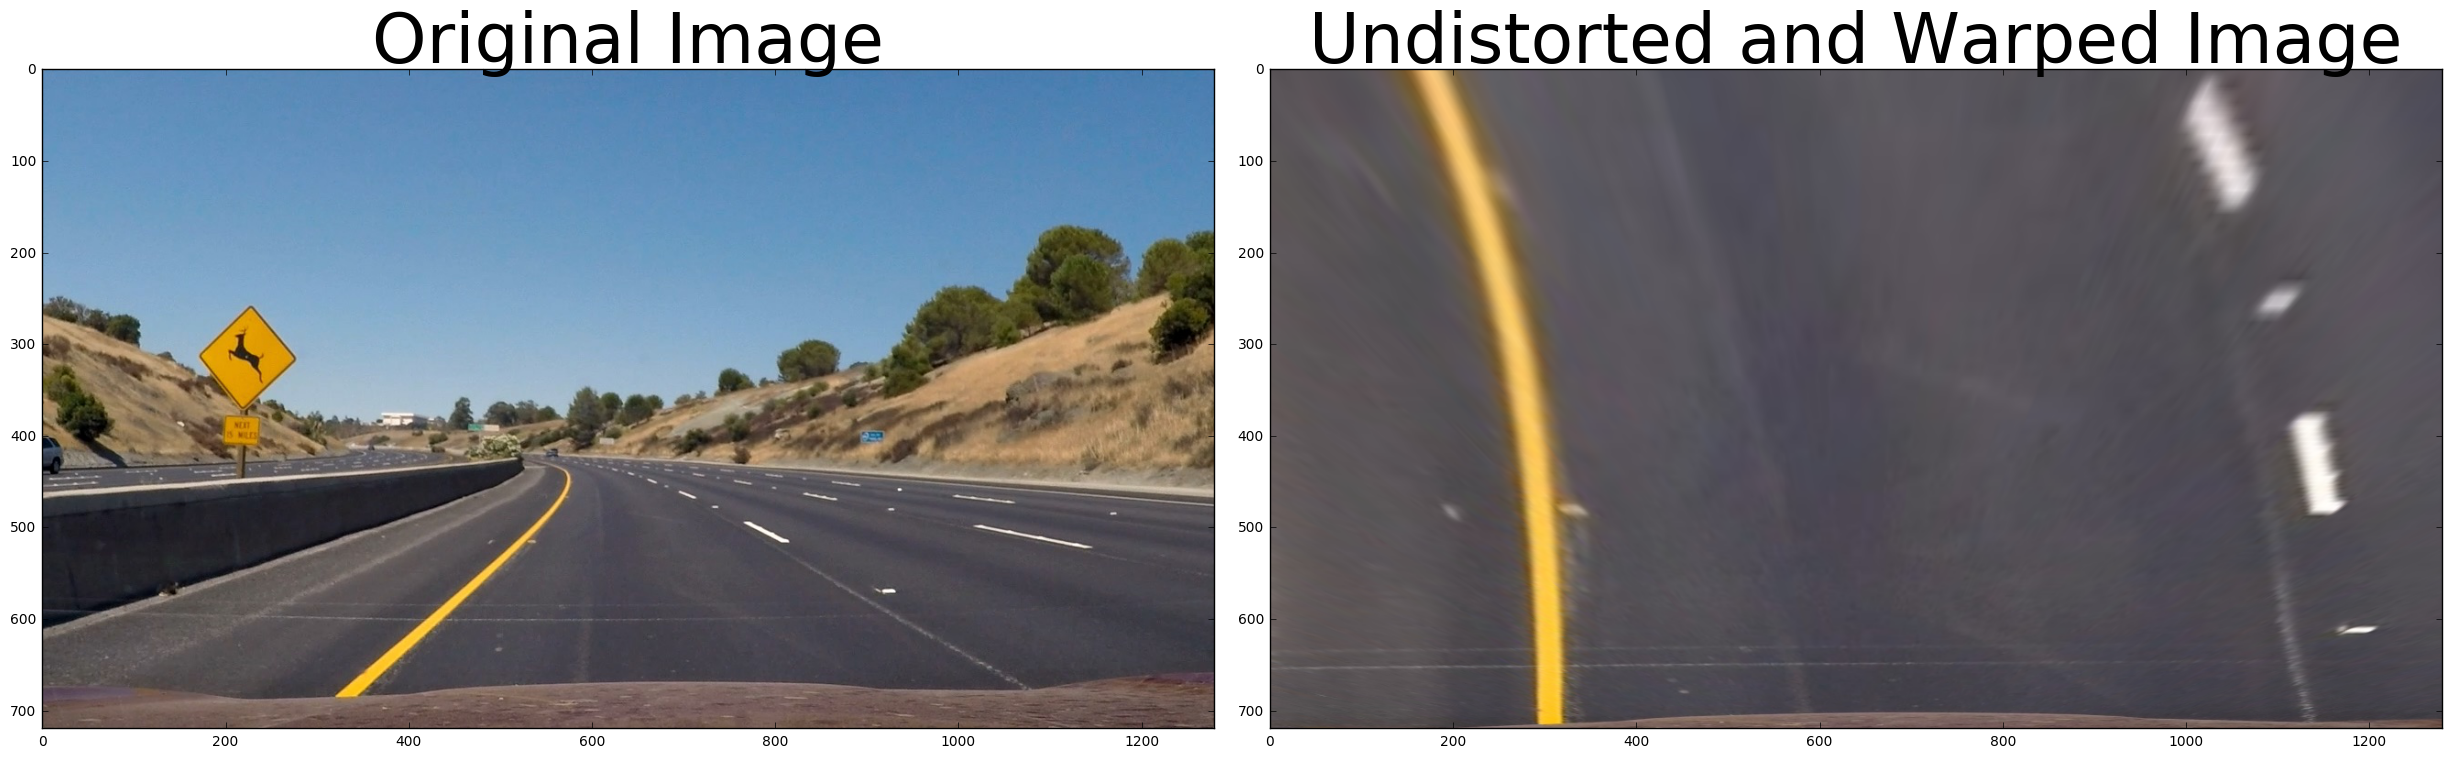

In [13]:
# Cell 13
image = mpimg.imread('./test_images/test2.jpg')
#contours = np.array(
#              [[200, 720],
#               [560,480],
#               [740, 480],
#              [1120, 720]])
#image = cv2.drawContours(image, [contours], -1, (0,255,0), 3)
undist = cv2.undistort(image, mtx, dist, None, mtx)
nx = 9
ny = 6
binary_warped, perspective_M,Minv = corners_unwarp(undist, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [15]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [17]:
# Cell 17
def get_curvature(lefty,righty,left_fit,right_fit,leftx,rightx,Debug=False):
       ##get curvature

        y_eval = np.max(lefty)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        if Debug:
            print(left_curverad, right_curverad)

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        if Debug:
            print(left_curverad, 'm', right_curverad, 'm')

        return left_curverad, right_curverad

In [18]:
# Cell 18
def calc_offset(undist, left_fit, right_fit):
    #Calculate vehicle offset from lane center, in meters
    # Calculate vehicle center offset in pixels
    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

    # Convert pixel offset to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix

    return vehicle_offset


In [19]:
# Cell 19
def Lane_Finder(binary_warped):
        # Choose the number of sliding windows
        nwindows = 9
     # Set the width of the windows +/- margin
        margin = 100
    # Set minimum number of pixels found to recenter window
        minpix = 50


        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint


        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]

        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)


        return left_fit, right_fit, lefty, righty, leftx, rightx



In [24]:
#  Cell 24
def draw_image(binary_warped,left_fit,right_fit,Minv,image,undist, vehicle_offset,left_curverad,right_curverad):

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])


        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        cv2.putText(result, 'Vehicle is {:.2f}m off center'.format(vehicle_offset), (100,80), fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1, color=(255,255,255), thickness = 1)
        cv2.putText(result, 'Left Radius of Curvature {}(m)'.format(left_curverad), (100,120),fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale =1, color=(255,255,255), thickness = 1)
        cv2.putText(result, 'Right Radius of Curvature {}(m)'.format(right_curverad), (100,160), fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(255,255,255), thickness = 1)

        return result


In [21]:
def process_vid(image):

    undist = cv2.undistort(image, mtx, dist, None, mtx)
    thresholded_image = combined_thresh(image)
    binary_warped, perspective_M,Minv = corners_unwarp(thresholded_image, nx, ny, mtx, dist)

    # Choose the number of sliding windows
    nwindows = 9
     # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    if not Left.detected:
        #print("if")

        left_fit, right_fit,lefty,righty,leftx, rightx = Lane_Finder(binary_warped)

        left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]

        right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

        ##get curvature
        left_curverad,right_curverad =  get_curvature(lefty,righty,left_fit,right_fit,leftx,rightx,Debug=False)

        #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


        Left.current_fit=left_fit
        Right.current_fit=right_fit
        Left.detected=True
        Right.detected=True

    else:


        left_fit=Left.current_fit
        right_fit=Right.current_fit


        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)


    ##get curvature
        left_curverad,right_curverad =  get_curvature(lefty,righty,left_fit,right_fit,leftx,rightx,Debug=False)


        Left.current_fit=left_fit
        Right.current_fit=right_fit


        #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



    vehicle_offset =  calc_offset(undist, left_fit, right_fit)
    if vehicle_offset < 0.1:
       result = draw_image(binary_warped,left_fit,right_fit,Minv,image,undist,vehicle_offset, left_curverad,right_curverad)


    else:

       left_fit,right_fit, lefty, righty, leftx, rightx=Lane_Finder(binary_warped)

       left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]

       right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

        ##get curvature
       left_curverad,right_curverad =  get_curvature(lefty,righty,left_fit,right_fit,leftx,rightx,Debug=False)

       Left.current_fit=left_fit
       Right.current_fit=right_fit
       Left.detected=True
       Right.detected=True

       result = draw_image(binary_warped,left_fit,right_fit,Minv,image,undist,vehicle_offset, left_curverad,right_curverad)
    return result


/home/prasad/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


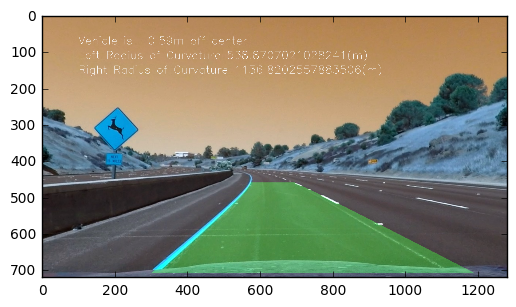

In [25]:
Left  = Line()
Right = Line()
nx = 9
ny = 6
# Read in an image and grayscale it
image = cv2.imread('./test_images/test2.jpg')
a = process_vid(image)
plt.imshow(a)


In [29]:
#code cell 18
from moviepy.editor import VideoFileClip
Left=Line()
Right=Line()
nx = 9
ny = 6
video_output = 'result.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [10:18<00:00,  2.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

